In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import numpy as np

from qiskit.circuit.library import PauliFeatureMap
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit import BasicAer
from qiskit.utils import algorithm_globals
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt



In [2]:
train = pd.read_csv("../data/train_small.csv")
test = pd.read_csv("../data/test_fe.csv")

#cols = ['age','roomservice', 'spa', 'vrdeck', 'homeplanet_earth', 'homeplanet_europa', 'homeplanet_mars', 'transported']

#train = train[cols]
x_train_use, y_train_use = train.drop("target", axis = 1), train["target"]

x_train_use = x_train_use.to_numpy()
y_train_use = y_train_use.to_numpy()



In [3]:
num_qubits=train.shape[0]-1
taus = [1, 10, 20, 50, 100, 200, 300, 400]
#taus=[400,500]
Cs = [10, 100, 200, 500, 750, 1000]

import time

from sklearn.metrics import classification_report,f1_score, precision_score, recall_score, confusion_matrix

#test = test[cols]

x_test, y_test = test.drop("target", axis =1), test["target"]

x_test = x_test.to_numpy()
y_test = y_test.to_numpy()



In [4]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(conf_matrix,tau, C):
    #num = len(os.listdir("../vqc_conf/train_"))
    conf_num = "../conf/pegasos_conf/" + str(tau) + "_" + str(C) + ".png"
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.savefig(conf_num)
    #plt.show()
    


/Users/mandali/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandali/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandali/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mandali/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_cl

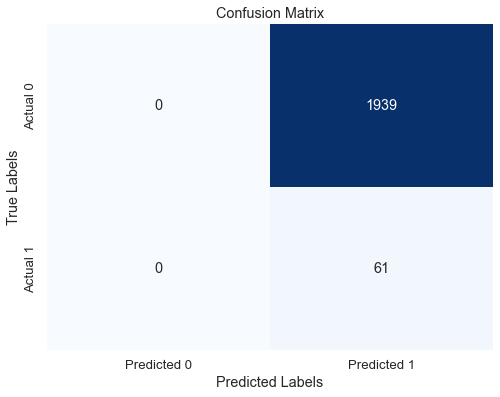

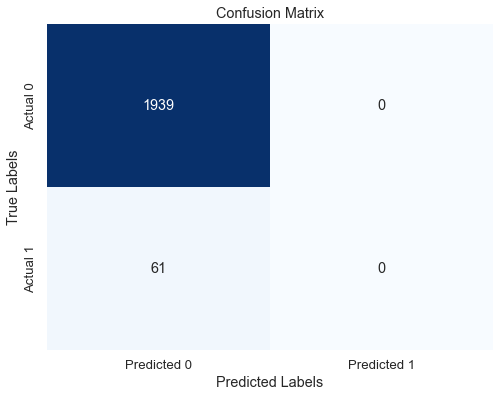

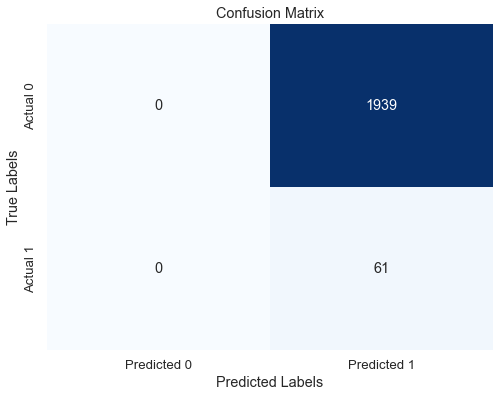

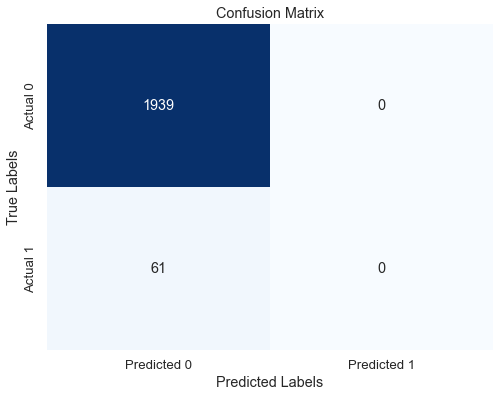

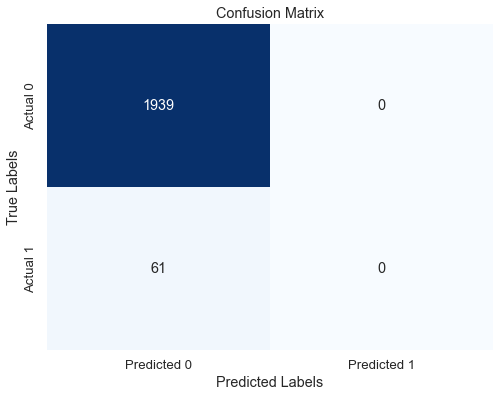

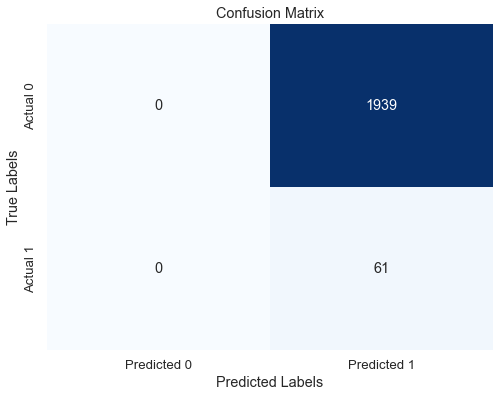

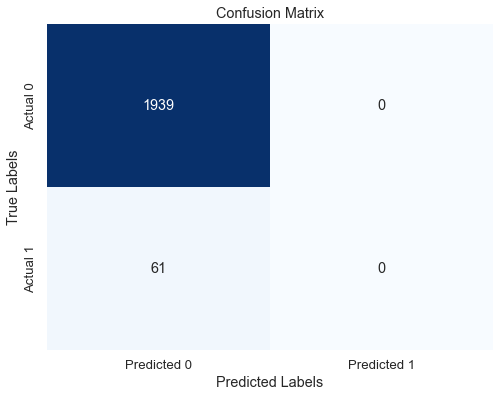

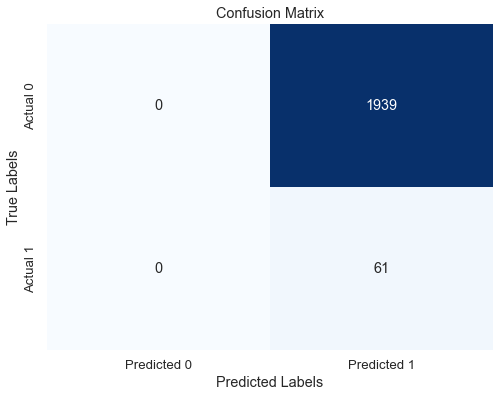

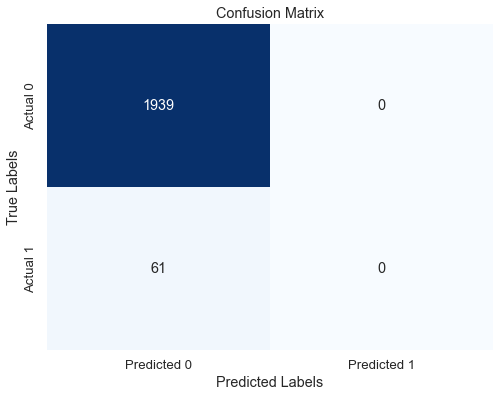

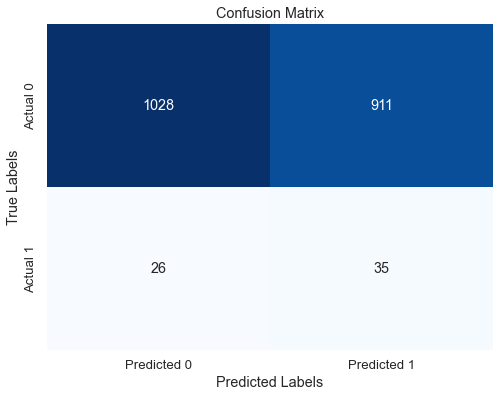

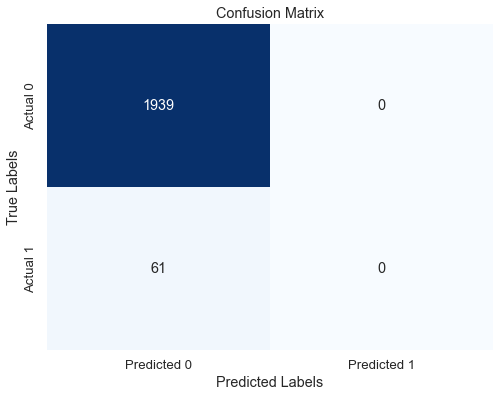

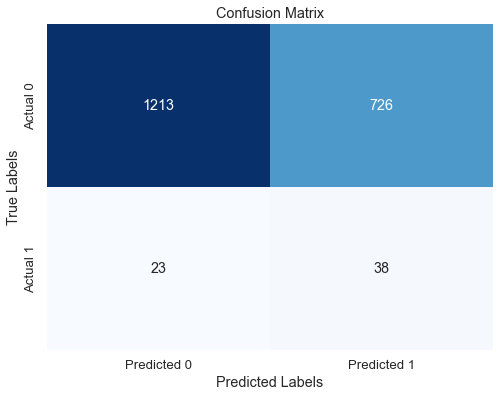

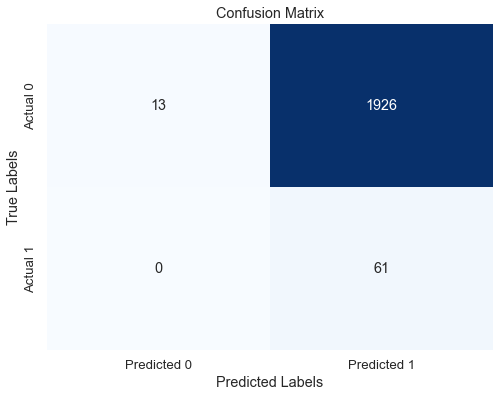

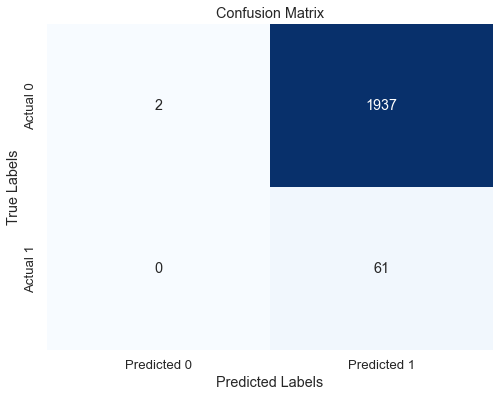

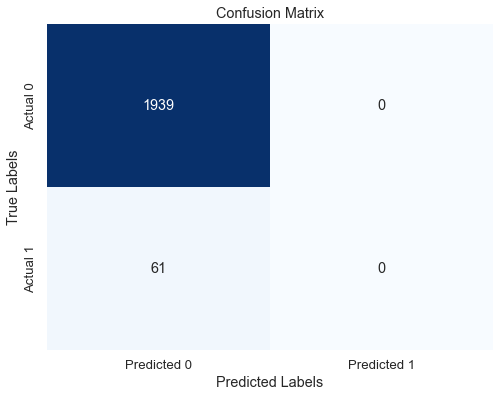

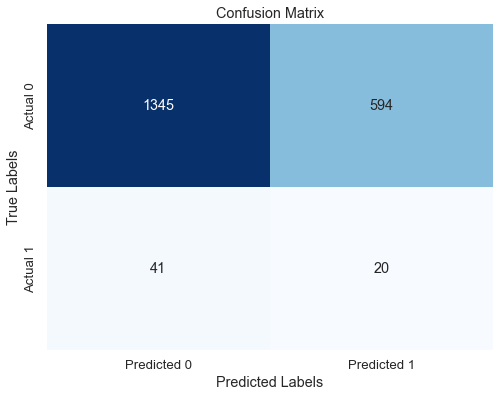

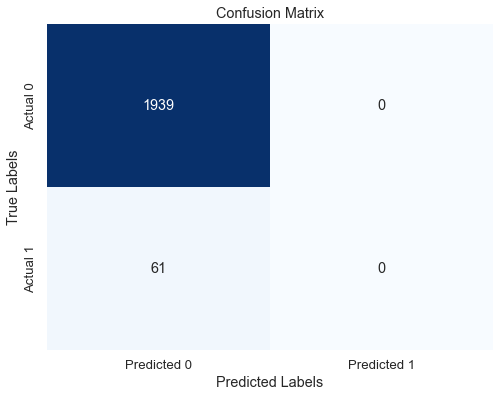

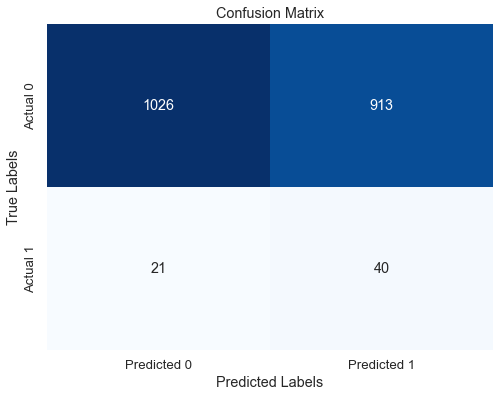

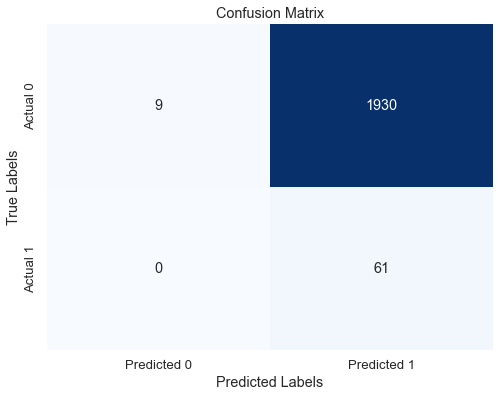

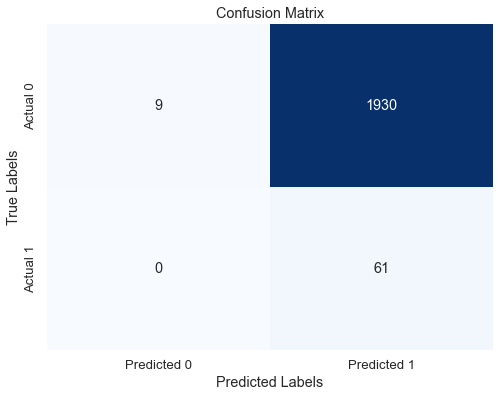

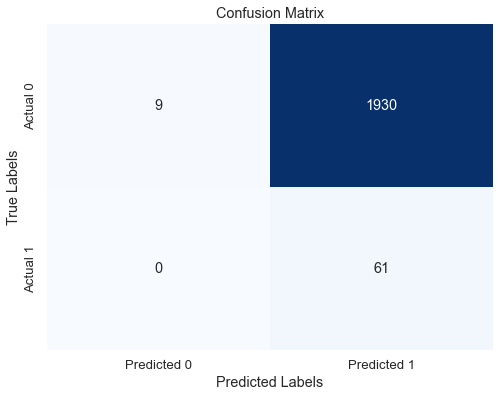

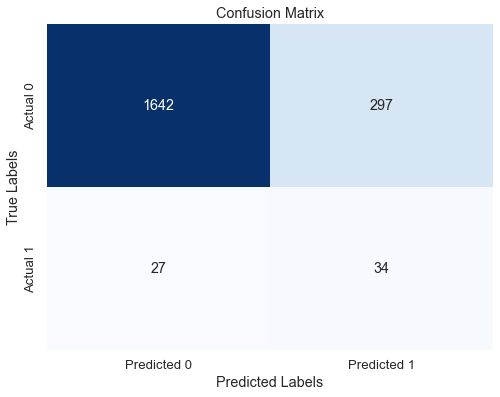

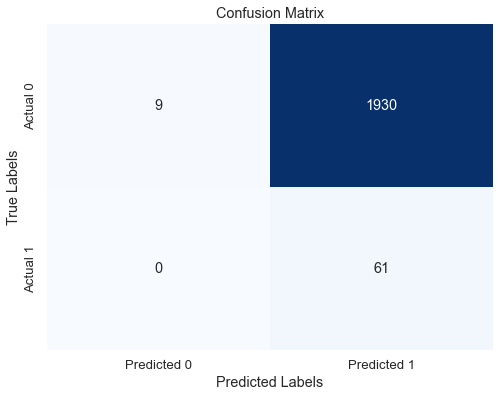

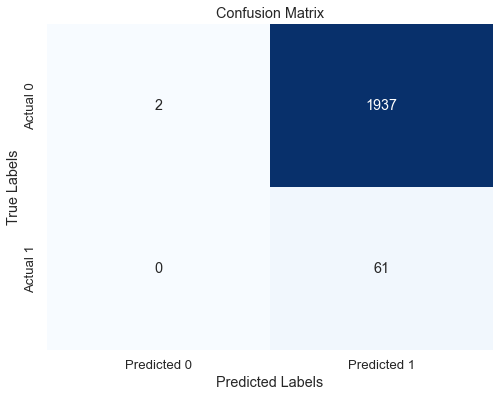

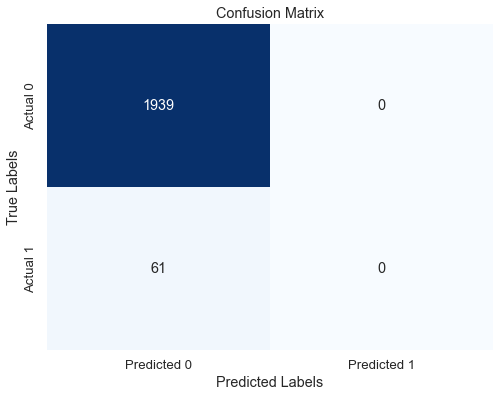

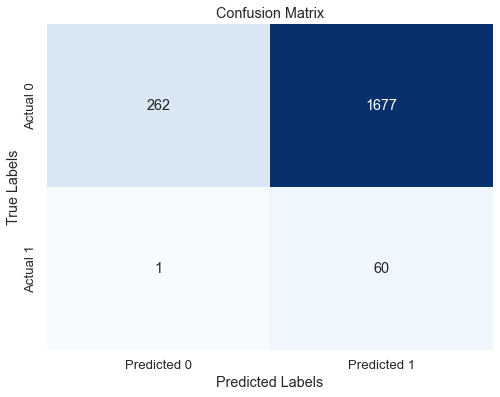

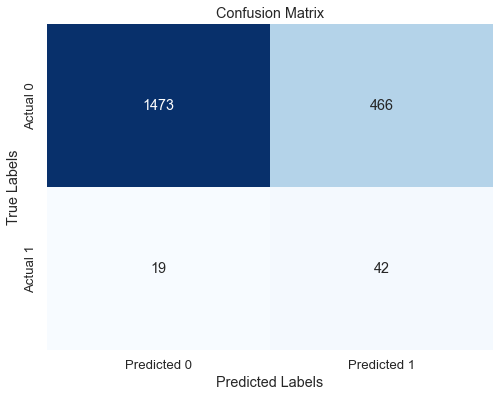

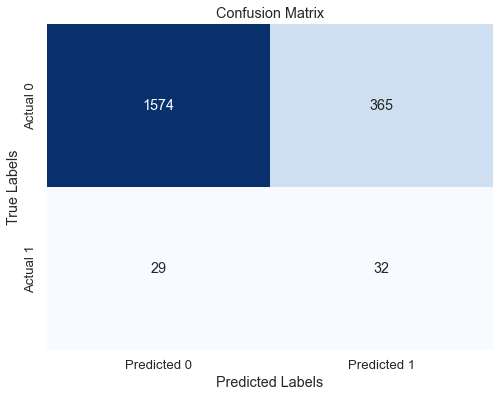

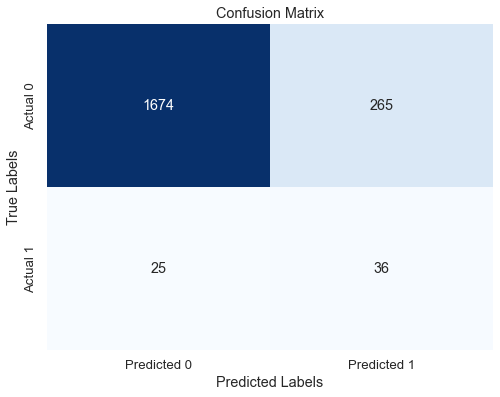

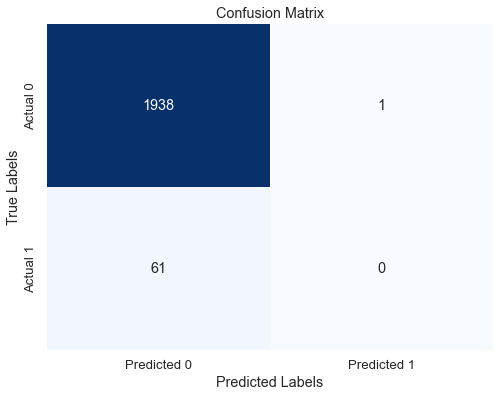

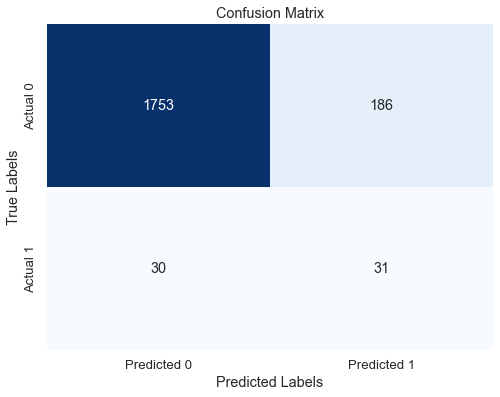

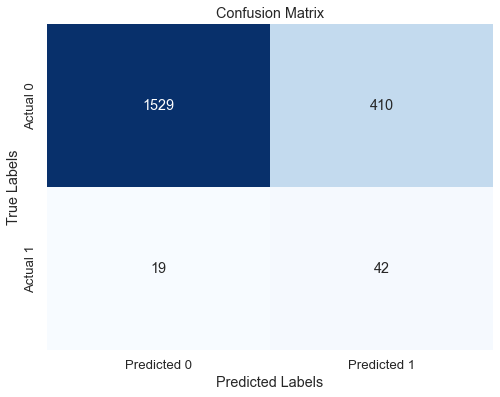

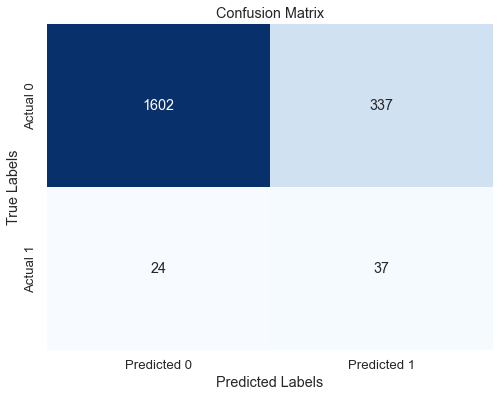

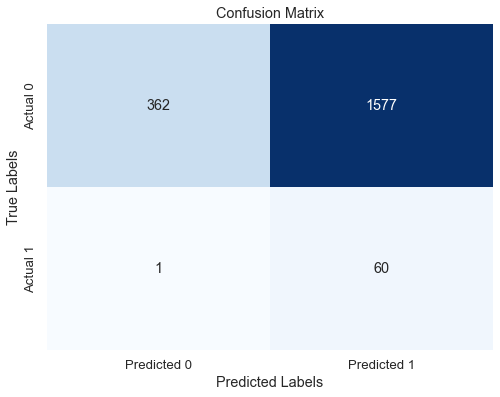

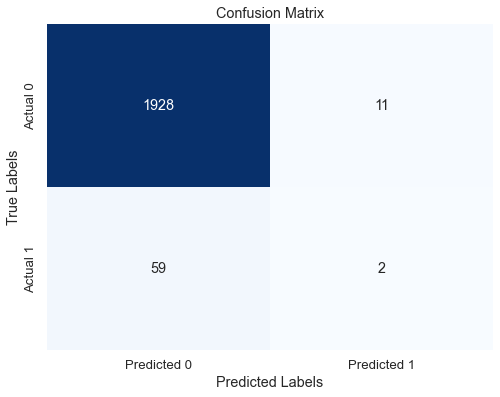

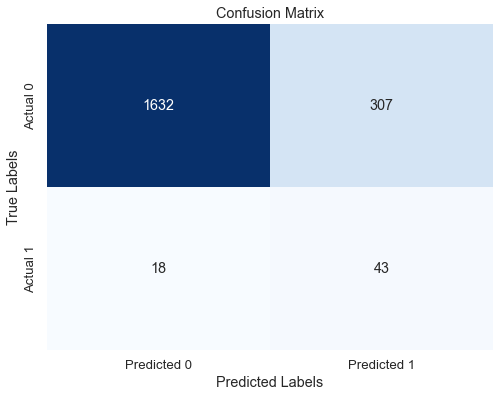

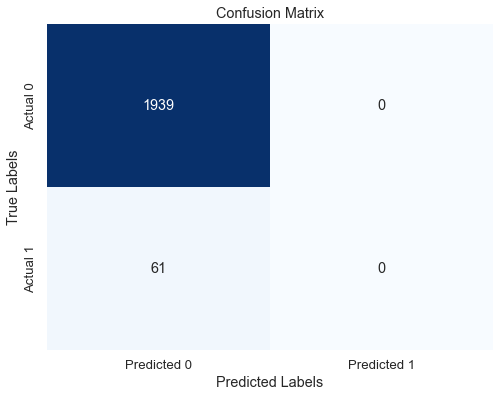

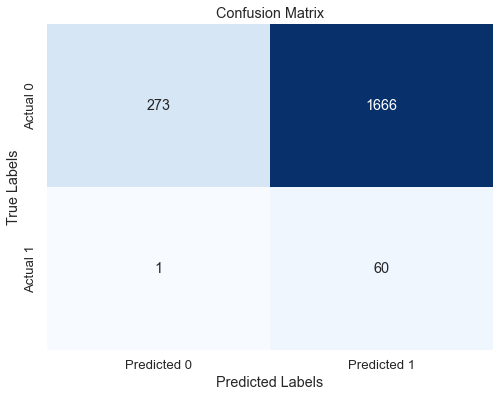

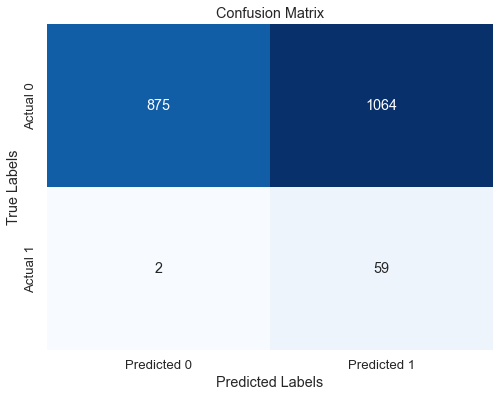

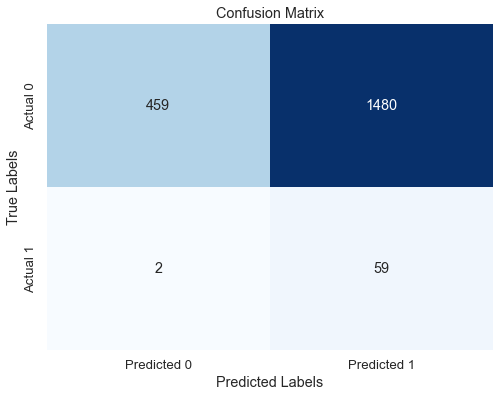

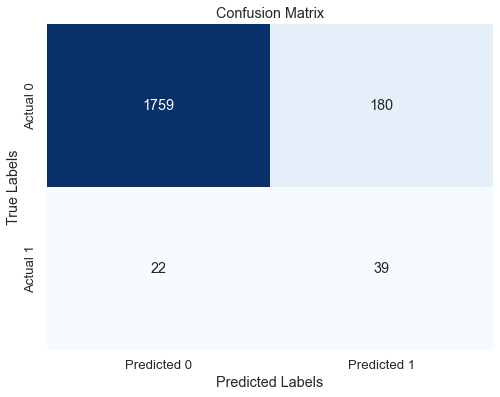

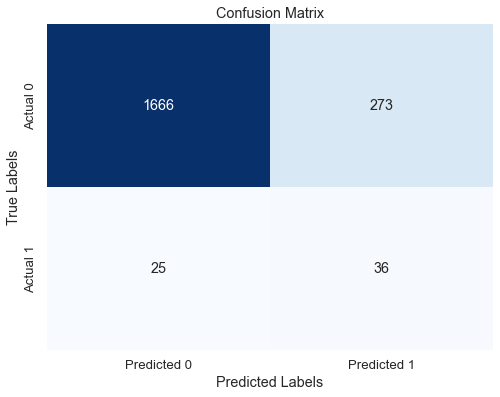

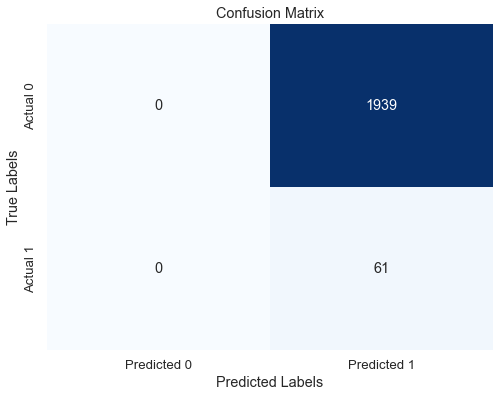

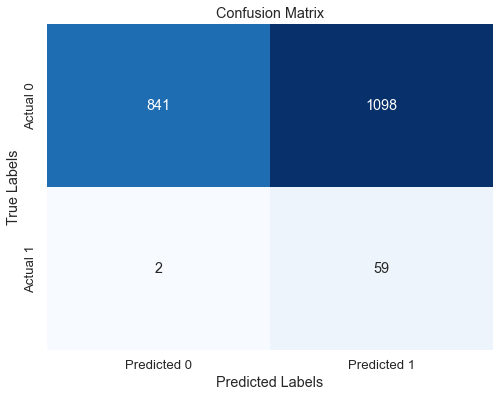

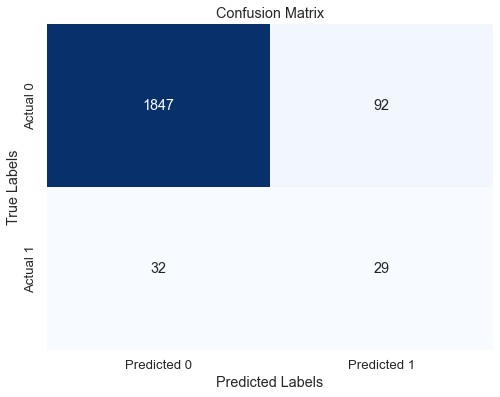

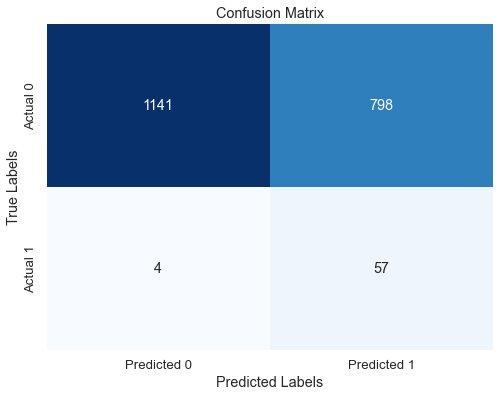

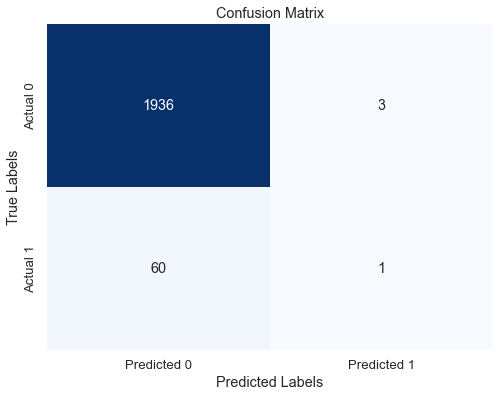

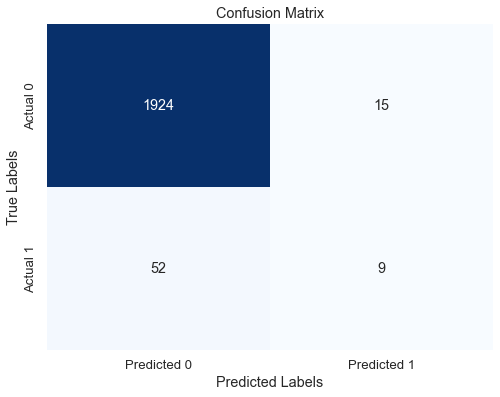

In [5]:
from qiskit_machine_learning.algorithms import PegasosQSVC
from itertools import product
import time

algorithm_globals.random_seed = 12345

feature_map = PauliFeatureMap(feature_dimension=num_qubits, reps=1)

qkernel = FidelityQuantumKernel(feature_map=feature_map)

results = {}
predicts={}
conf_matrixs={}


# Loop over all combinations of hyperparameters
for tau, C in product(taus, Cs):
    model = PegasosQSVC(quantum_kernel=qkernel, C=C, num_steps=tau)
    
    start = time.time()
    model.fit(x_train_use, y_train_use)
    end = time.time()
    elapsed = end - start
    
    pred_use = model.predict(x_train_use)
    pred_test = model.predict(x_test)
    conf_matrix = confusion_matrix(y_test, pred_test)
    #conf_matrixs[(tau, C)] = {'Conf_Matrix': conf_matrix}
    plot_confusion_matrix(conf_matrix, tau, C)
    
    f1_train = f1_score(y_train_use, pred_use)
    prec_train = precision_score(y_train_use, pred_use)
    recall_train = recall_score(y_train_use, pred_use)


    f1_test = f1_score(y_test, pred_test)
    prec_test = precision_score(y_test, pred_test)
    recall_test = recall_score(y_test, pred_test)

    df = pd.DataFrame()
    df["f1_test"] = [f1_test]
    df["f1_train"] = f1_train
    df["prec_train"] = prec_train
    df["prec_test"] = prec_test
    df["recall_train"] = recall_train
    df["recall_test"] = recall_test
    df["elapsed"] = elapsed
    df["model"] = "Pegasos QSVC"
    df["tau"]=tau
    df["C"]=C

    
    #num = len(os.listdir("../model"))
    pegasos_mod_num = "../model/mod_pegasos_" + str(tau)+'_'+str(C) + ".model"
    model.save(pegasos_mod_num)
    #num = len(os.listdir("../result"))
    
    df.to_csv("../results/regular/pegasos_results/res_pegasos_" + str(tau)+"_"+str(C) + ".csv", index = False)